In [122]:
import scipy.io
from pathlib import Path
import numpy as np
import hsmm_mvpy as hmp
from collections import Counter
import mne
import xarray as xr
from mne.io import read_info
import matplotlib.pyplot as plt

In [ ]:
data = scipy.io.loadmat(Path("../data/ar/varForBumps135_100.mat"))

#### Create combined mne.info object

In [31]:
sat1_info["ch_names"]

['Fp1',
 'Fp2',
 'AFz',
 'F7',
 'F3',
 'Fz',
 'F4',
 'F8',
 'T7',
 'C3',
 'Cz',
 'C4',
 'T8',
 'P7',
 'P3',
 'Pz',
 'P4',
 'P8',
 'O1',
 'O2',
 'FC1',
 'FCz',
 'FC2',
 'FC5',
 'FC6',
 'CP5',
 'CP1',
 'CPz',
 'CP2',
 'CP6']

In [110]:
channel_data = scipy.io.loadmat(Path("../data/ar/chanlocs.mat"))
channels = [channel_data["chanlocs"][0][i][0][0] for i in range(32)]

sat1_info = read_info(Path("../data/sat1/preprocessed/processed_0001_epo.fif"))
sat1_channels = sat1_info["ch_names"]
sat1_channels_excl = [
    ch
    for ch in sat1_channels
    if ch not in ["FCz", "CPz", "Cz", "Fz", "Pz", "Fp1", "Fp2"]
]
sat1_only_channels = [ch for ch in sat1_channels_excl if ch not in channels]

combined_channels = list(set(channels).union(set(sat1_channels_excl)))

info = mne.create_info(combined_channels, sfreq=100, ch_types="eeg")
# AR channel naming convention
ch_dict = {
    "FP1": "Fp1",
    "FP2": "Fp2",
    "FPZ": "Fpz",
    "FZ": "Fz",
    "FCZ": "FCz",
    "CZ": "Cz",
    "CPZ": "CPz",
    "PZ": "Pz",
    "POZ": "POz",
    "OZ": "Oz",
}
info.rename_channels(ch_dict)  # Naming convention
info.set_montage("standard_1020")  # Standard 10-20 electrode montage
info.rename_channels({v: k for k, v in ch_dict.items()})
info["bads"].extend(sat1_only_channels)
# Result: mne.Info object with 44 channels

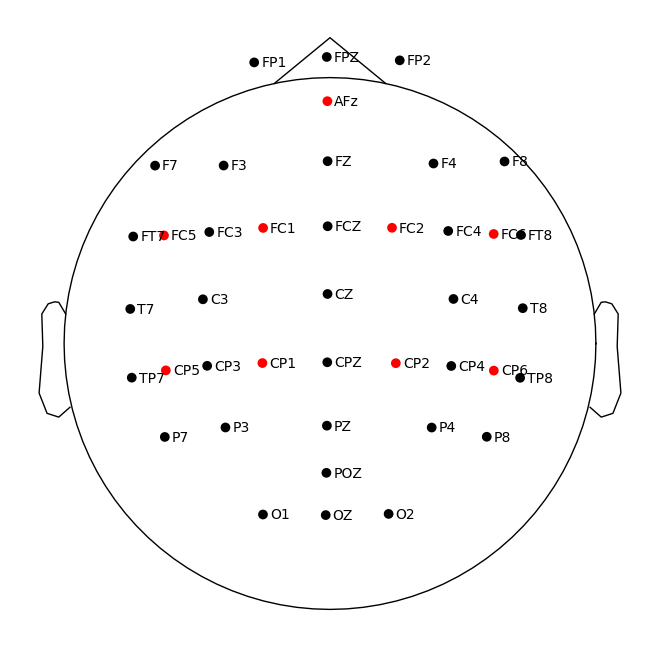

In [123]:
info.plot_sensors(show_names=True)
plt.show()

In [124]:
# Ensure data is inserted in this order
# Create nparray of zeros, insert at index of channel name in ar chanlocs
info["ch_names"]

['P8',
 'CP2',
 'FC4',
 'P7',
 'FT8',
 'FC1',
 'FC3',
 'FCZ',
 'P4',
 'T8',
 'F7',
 'CP5',
 'OZ',
 'T7',
 'FP2',
 'CP4',
 'P3',
 'O1',
 'FC2',
 'FC6',
 'CPZ',
 'FP1',
 'CP1',
 'C3',
 'TP7',
 'TP8',
 'CZ',
 'CP3',
 'POZ',
 'F4',
 'F8',
 'CP6',
 'O2',
 'C4',
 'F3',
 'PZ',
 'AFz',
 'FT7',
 'FZ',
 'FPZ',
 'FC5']

#### Create RawArray

In [125]:
# Want (participant, epochs, channels, samples) dimension
# Count occurrences of each subject to get number of epochs
counts = Counter(data["subjects"].squeeze())

# Calculate the differences between consecutive elements to find max epoch length
epoch_lengths = data["y"] - data["x"] + 1
n_samples = np.max(epoch_lengths)

participant_id = data["subjects"][0][0]
participant_epochs = np.zeros((counts[participant_id], 32, n_samples))
result = []
epoch_counter = 0
for start, end, cond, participant in zip(
    data["x"], data["y"], data["conds"], data["subjects"]
):
    # All epoch timings
    # NOTE: NOT ZERO-INDEXED, INDEX 1 IS FIRST SAMPLE
    new_participant = participant[0]
    # print(new_participant)
    if new_participant != participant_id:
        participant_id = new_participant
        # Process data and reset lists?
        result.append(participant_epochs)
        participant_epochs = np.zeros((counts[participant_id], 32, n_samples))
        epoch_counter = 0
    # print(start, end, cond, participant)
    # subtract one because epoch indices are 1-indexed and python is 0-indexed
    # Take transpose since data is originally (samples, channels)
    epoch_data = data["data"][start[0] - 1 : end[0] - 1].T
    # Pad every epoch to max samples length
    epoch_data = np.pad(
        epoch_data,
        ((0, 0), (0, n_samples - epoch_data.shape[1])),
        mode="constant",
        constant_values=np.nan,
    )
    participant_epochs[epoch_counter] = epoch_data
    epoch_counter += 1
# Append the last participant's epochs to the result list
result.append(participant_epochs)

In [156]:
sat1_channels_upper = [ch.upper() for ch in sat1_channels]
sat1_channels_upper[sat1_channels_upper.index("AFZ")] = "AFz"
sat1_ch_indices = mne.pick_channels(info["ch_names"], sat1_channels_upper)

max_n_epochs = np.max([participant.shape[0] for participant in result])
# Create list of ndarrays with epochs for each participant
result_new = []
for participant in result:
    epoch_results = []
    for epoch in participant:
        # (32, 300) to (300, 32)
        # epoch = epoch.T
        epoch_data = np.zeros((len(combined_channels), n_samples))
        for i, ch in enumerate(epoch):
            if channels[i] in combined_channels:
                epoch_data[info["ch_names"].index(channels[i]), :] = epoch[i]
        raw_arr = mne.io.RawArray(epoch_data, info, verbose=False)
        raw_arr, _ = mne.set_eeg_reference(
            raw_arr, ref_channels="average", verbose=False
        )
        raw_arr.interpolate_bads(verbose=False)
        raw_arr.pick(sat1_ch_indices)
        epoch_results.append(raw_arr.get_data())

    result_new.append(np.stack(epoch_results, axis=0))

/tmp/ipykernel_12163/808342738.py:3: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  sat1_ch_indices = mne.pick_channels(info["ch_names"], sat1_channels_upper)


In [158]:
max_length = np.max([res.shape[0] for res in result_new])
padded_array = np.empty((len(result_new), max_length, 30, n_samples))
for i, res in enumerate(result_new):
    padded_result = np.pad(
        res,
        ((0, max_length - res.shape[0]), (0, 0), (0, 0)),
        mode="constant",
        constant_values=np.nan,
    )
    padded_array[i] = padded_result

In [168]:
participants = [f"AR_{i}" for i in range(1, 21)]
hmp_data = hmp.utils.hmp_data_format(
    padded_array, sfreq=100, participants=participants, channels=raw_arr.ch_names
)

hmp_data = hmp_data.assign_attrs(sfreq=100, lowpass=35.0, highpass=1.0)

In [174]:
raw_arr.info.save('../data/ar/ar_info.fif')

## Re-order channels

In [11]:
channel_data = scipy.io.loadmat(Path("../data/ar/chanlocs.mat"))
channels = [channel_data["chanlocs"][0][i][0][0] for i in range(32)]
channels
# Create new channel ordering to adhere as close as possible to SAT 1 ordering
reindex_channels = channels.copy()
reindex_channels[1] = "FP2"
reindex_channels[2] = "FPZ"
reindex_channels[8:13] = channels[13:18]
reindex_channels[13:18] = channels[23:28]
reindex_channels[18:19] = ["O1", "O2"]
reindex_channels[20:25] = ["FC3", "FCZ", "FC4", "FT7", "FT8"]
reindex_channels[25:30] = channels[18:23]
reindex_channels[30:33] = ["trash1", "trash2"]

## Convert matlab data to 4D NumPy Array to prepare for HMP

In [12]:
# Want (participant, epochs, channels, samples) dimension
# Count occurrences of each subject to get number of epochs
counts = Counter(data["subjects"].squeeze())

# Calculate the differences between consecutive elements to find max epoch length
epoch_lengths = data["y"] - data["x"] + 1
n_samples = np.max(epoch_lengths)

participant_id = data["subjects"][0][0]
participant_epochs = np.zeros((counts[participant_id], 32, n_samples))
result = []
epoch_counter = 0
for start, end, cond, participant in zip(
    data["x"], data["y"], data["conds"], data["subjects"]
):
    # All epoch timings
    # NOTE: NOT ZERO-INDEXED, INDEX 1 IS FIRST SAMPLE
    new_participant = participant[0]
    # print(new_participant)
    if new_participant != participant_id:
        participant_id = new_participant
        # Process data and reset lists?
        result.append(participant_epochs)
        participant_epochs = np.zeros((counts[participant_id], 32, n_samples))
        epoch_counter = 0
    # print(start, end, cond, participant)
    # subtract one because epoch indices are 1-indexed and python is 0-indexed
    # Take transpose since data is originally (samples, channels)
    epoch_data = data["data"][start[0] - 1 : end[0] - 1].T
    # Pad every epoch to max samples length
    epoch_data = np.pad(
        epoch_data,
        ((0, 0), (0, n_samples - epoch_data.shape[1])),
        mode="constant",
        constant_values=np.nan,
    )
    participant_epochs[epoch_counter] = epoch_data
    epoch_counter += 1
# Append the last participant's epochs to the result list
result.append(participant_epochs)

Pad every participant + epoch to max epoch participant

In [13]:
max_length = np.max([res.shape[0] for res in result])
padded_array = np.empty((len(result), max_length, 32, n_samples))
for i, res in enumerate(result):
    padded_result = np.pad(
        res,
        ((0, max_length - res.shape[0]), (0, 0), (0, 0)),
        mode="constant",
        constant_values=np.nan,
    )
    padded_array[i] = padded_result

In [14]:
participants = [f"AR_{i}" for i in range(1, 21)]
hmp_data = hmp.utils.hmp_data_format(
    padded_array, sfreq=100, participants=participants, channels=channels
)
# Re-order channels to be as similar as possible to SAT1
# hmp_data = hmp_data.reindex(channels=reindex_channels).drop_sel(
#     channels=["trash1", "trash2"]
# )

hmp_data = hmp_data.assign_attrs(sfreq=100, lowpass=35.0, highpass=1.0)

In [169]:
hmp_data

<xarray.Dataset>
Dimensions:      (participant: 20, epochs: 789, channels: 30, samples: 300)
Coordinates:
  * participant  (participant) <U5 'AR_1' 'AR_2' 'AR_3' ... 'AR_19' 'AR_20'
  * epochs       (epochs) int64 0 1 2 3 4 5 6 7 ... 782 783 784 785 786 787 788
  * channels     (channels) <U3 'P8' 'CP2' 'P7' 'FC1' ... 'PZ' 'AFz' 'FZ' 'FC5'
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 293 294 295 296 297 298 299
Data variables:
    data         (participant, epochs, channels, samples) float64 -0.7747 ......
Attributes:
    sfreq:     100
    offset:    0
    lowpass:   35.0
    highpass:  1.0

Add condition and RT coordinates

In [170]:
conditions = ["TargetFan1", "TargetFan2", "FoilFan1", "FoilFan2"]
epoch_counter = 0
participant_id = data["subjects"][0][0] - 1
results_conditions = np.full(
    (len(hmp_data.participant), len(hmp_data.epochs)), fill_value="", dtype=object
)
results_rts = np.full(
    (len(hmp_data.participant), len(hmp_data.epochs)), fill_value=np.nan
)
for cond, length, participant in zip(data["conds"], epoch_lengths, data["subjects"]):
    new_participant = participant[0] - 1
    if new_participant != participant_id:
        participant_id = new_participant
        epoch_counter = 0
    results_conditions[participant_id, epoch_counter] = conditions[cond[0] - 1]
    results_rts[participant_id, epoch_counter] = (
        float(length[0]) / hmp_data.sfreq
    ) * 1000
    epoch_counter += 1

In [171]:
hmp_data = hmp_data.assign_coords(
    {
        "cond": (("participant", "epochs"), results_conditions),
        "RT": (("participant", "epochs"), results_rts),
    }
)

In [172]:
hmp_data.to_netcdf(Path("../data/ar/data_new.nc"))

Compare to SAT1 HMP data

In [5]:
hmp_data = xr.load_dataset(Path("../data/ar/data.nc"))

In [6]:
hmp_data_sat1 = hmp.utils.load_data(Path("../data/sat1/data.nc"))
hmp_data_sat1

<xarray.Dataset>
Dimensions:      (epochs: 200, channels: 30, samples: 993, participant: 25)
Coordinates:
  * epochs       (epochs) int64 0 1 2 3 4 5 6 7 ... 193 194 195 196 197 198 199
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 986 987 988 989 990 991 992
    stim         (participant, epochs) float64 nan 1.0 1.0 1.0 ... 2.0 nan 2.0
    resp         (participant, epochs) object '' 'resp_left' ... '' 'resp_left'
    RT           (participant, epochs) float64 nan 683.0 ... nan 1.02e+03
    cue          (participant, epochs) object '' 'SP' 'AC' 'SP' ... 'SP' '' 'AC'
    movement     (participant, epochs) object '' 'stim_left' ... '' 'stim_right'
    trigger      (participant, epochs) object '' ... 'AC/stim_right/resp_left'
  * participant  (participant) object '0001' '0002' '0003' ... '0024' '0025'
Data variables:
    data         (participant, epochs, channels, samples) float64 nan ... nan
Attributes:
    sfreq:           500.0
    offset:          0
    lowpass:         35.0
    highpass:        1.0
    lower_limit_RT:  0.2
    upper_limit_RT:  2

In [13]:
ar_channels = list(hmp_data.channels.to_numpy())

In [16]:
sat1_channels = list(hmp_data_sat1.channels.to_numpy())
sat1_channels = [ch.upper() for ch in sat1_channels]

In [17]:
channels_both = list(set(ar_channels).intersection(set(sat1_channels)))

In [18]:
channels_both

['T7',
 'CPZ',
 'O2',
 'FCZ',
 'O1',
 'P8',
 'P4',
 'T8',
 'F4',
 'C4',
 'FP1',
 'C3',
 'FP2',
 'P3',
 'F8',
 'P7',
 'F3',
 'F7',
 'PZ',
 'FZ',
 'CZ']

Deprecated, exploring the dataset

In [3]:
data["info"]
# Sampling freq: 100Hz
# Bandwidth filter 1-35 Hz
# Trial length [onset, sep]
# Conditions: TargetFan1, TargetFan2, FoilFan1, FoilFan2
# Max length is 300 samples, 3s

array(['varibles for HSMM code from Qiong; 100 Hz sampling freq.; filter 1 to 35 Hz;lenght trials[Onset, sep], conditions: TargetFan1, TagetFan2, FoilFan1, FoilFan2'],
      dtype='<U156')

In [9]:
# Conditions per epoch index
data["conds"].shape

(14496, 1)

In [13]:
data["subjects"].shape

(14496, 1)

In [17]:
data["data"][0]

array([10.993831 ,  8.723188 , 10.027045 ,  7.504407 , 18.959301 ,
       21.560759 , 14.805117 ,  9.172554 ,  4.9811172, 15.159214 ,
       21.402538 , 16.80298  , 12.275539 ,  6.392374 , 11.632956 ,
       17.042414 , 16.531641 ,  9.345386 ,  4.4990344,  8.106483 ,
       13.541809 , 13.008925 ,  8.935929 ,  5.1235404,  7.2147107,
        9.932727 , 12.233317 , 10.30872  ,  7.9629884,  5.5633454,
        4.691024 , 10.233817 ], dtype=float32)

In [44]:
# Every point of data, electrodes?
data["data"][0:137]

array([[10.993831 ,  8.723188 , 10.027045 , ...,  5.5633454,  4.691024 ,
        10.233817 ],
       [13.505087 , 11.234549 , 10.693406 , ...,  9.04013  ,  9.229184 ,
        13.818634 ],
       [13.468838 ,  9.2393055,  9.529629 , ...,  9.169965 ,  9.655204 ,
        14.178063 ],
       ...,
       [ 3.4505954,  3.7852283,  3.0477   , ...,  2.1767552, -1.1543489,
        -2.7878852],
       [ 5.2995434,  6.2415214,  5.163968 , ...,  3.698343 ,  4.100088 ,
         3.7230742],
       [-6.627756 , -6.254589 , -4.2560973, ..., 11.651623 , 13.535622 ,
        17.530716 ]], dtype=float32)

In [43]:
# For every sample, which participant does it belong to
print(data["subjects"].shape)
data["subjects"]

(14496, 1)


In [ ]:
# Code Gabriel
mat = scipy.io.loadmat(
    Path("../data/ar/varForBumps135_100.mat")
)  # Where the .mat file with all the data and necessary infos is
starts = np.array(mat["x"][:, 0]) - 1  # correcting to be 0 indexed
ends = np.array(mat["y"][:, 0]) - 1  # correcting to be 0 indexed
subjects = np.array(mat["subjects"])[:] - 1  # correcting to be 0 indexed


### Recovering RTs, trials and participants
durations = ends - starts + 1
limits = np.cumsum(durations)
limits = np.concatenate([[0], limits])  # starts with one end concatenated
participant, trials = np.unique(subjects, return_counts=True)
channel_data = mat["data"]
epoch_data = np.tile(np.nan, (len(participant), np.max(trials), 32, np.max(durations)))
conditions = np.tile(np.nan, (len(participant), np.max(trials)))

for trial in np.arange(len(durations)):
    if trial > 0 and subjects[trial] == subjects[trial - 1]:
        within_trial += 1
    else:
        within_trial = 0
    epoch_data[
        subjects[trial],
        within_trial,
        :,
        : durations[trial],
    ] = channel_data[limits[trial] : limits[trial + 1]].T
    conditions[subjects[trial], within_trial] = mat["conds"][trial]

epoch_data = hmp.utils.hmp_data_format(
    epoch_data, sfreq=100, events=conditions, participants=participant
)
epoch_data = epoch_data.rename({"events": "condition"})
epoch_data.to_netcdf(Path("../data/ar/data_g.nc"))